In [1]:
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import itertools
from itertools import permutations
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

2025-06-01 03:00:28.668639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748746828.860129      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748746828.918249      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [52]:
import pandas as pd

# 기본 경로
BASE_DIR = "/kaggle/input/global/"

# 데이터 불러오기
train_path = pd.read_csv(BASE_DIR + "train.csv")
test_df = pd.read_csv(BASE_DIR + "test.csv")
train_path.head()


,ID,sentence_0,sentence_1,sentence_2,sentence_3,answer_0,answer_1,answer_2,answer_3
0,TRAIN_0000,블록체인 기술은 투표 과정의 투명성을 크게 향상시킬 수 있다.,"이러한 특성은 유권자들에게 신뢰를 제공하며, 민주적 참여를 촉진하는 데 기여할 수 있다.",결과적으로 블록체인 기반의 투표 시스템은 공정하고 신뢰할 수 있는 선거 환경을 조성...,각 투표는 변경 불가능한 기록으로 저장되어 조작의 가능성을 원천적으로 차단한다.,0,3,1,2
1,TRAIN_0001,줄거리 자동 생성의 인공지능 알고리즘은 대량의 텍스트 데이터를 분석하여 핵심 정보를...,"결과적으로, 이러한 기술은 사용자에게 신속하고 효율적인 정보 전달을 가능하게 한다.",생성된 줄거리는 원본 텍스트의 의미를 유지하면서도 간결하게 요약된 형태로 제공된다.,"이 알고리즘은 자연어 처리 기술을 활용하여 문맥을 이해하고, 주요 사건과 등장인물을...",0,3,2,1
2,TRAIN_0002,"마지막으로, 키친타올을 보관할 때는 쉽게 접근할 수 있는 곳에 두어 낭비를 방지하는...",재사용 가능한 천이나 스펀지를 활용하면 키친타올의 필요성을 줄일 수 있다.,물기를 제거할 때는 가볍게 눌러주어 과도한 사용을 피할 수 있다.,키친타올을 절약하는 첫걸음은 필요한 양만큼만 사용하는 것이다.,3,2,1,0
3,TRAIN_0003,책의 페이지가 손상되지 않도록 수직으로 세워 두거나 평평하게 눕혀 보관하는 것이 좋다.,"정기적으로 먼지를 털어내고, 곰팡이나 해충의 발생 여부를 점검하는 것이 중요하다.",종이책은 직사광선이 닿지 않는 서늘하고 건조한 장소에 보관해야 한다.,"필요할 경우, 책을 보호하기 위해 커버를 씌우거나 전용 보관함에 넣는 방법도 고려할...",2,0,1,3
4,TRAIN_0004,"인공지능 모델은 반복적인 실험을 통해 지속적으로 학습하며, 이를 통해 발견의 정확성...",인공지능은 대량의 데이터를 분석하여 숨겨진 패턴과 상관관계를 발견하는 데 강력한 도...,"결국, 인공지능의 지원은 과학적 발견의 속도와 효율성을 혁신적으로 변화시킬 수 있는...",이러한 분석 결과는 연구자들에게 새로운 가설을 제시하고 실험 설계를 개선하는 데 기...,1,3,0,2


In [4]:
submission_path = pd.read_csv(BASE_DIR + "sample_submission.csv")

In [5]:
submission_path.info()
submission_path.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        1780 non-null   object
 1   answer_0  1780 non-null   int64 
 2   answer_1  1780 non-null   int64 
 3   answer_2  1780 non-null   int64 
 4   answer_3  1780 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 69.7+ KB


,ID,answer_0,answer_1,answer_2,answer_3
0,TEST_0000,0,1,2,3
1,TEST_0001,0,1,2,3
2,TEST_0002,0,1,2,3
3,TEST_0003,0,1,2,3
4,TEST_0004,0,1,2,3


In [6]:
# data_utils.py
import pandas as pd
import numpy as np

def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

def make_labels(df):
    # answer_0 ~ answer_3 → [문장0은 몇 번째, 문장1은 몇 번째, ...]
    answers = df[[f'answer_{i}' for i in range(4)]].values
    labels = []
    for row in answers:
        label = [0]*4
        for pos, sent_idx in enumerate(row):
            label[sent_idx] = pos
        labels.append(label)
    return np.array(labels)

# Dataset 클래스
 4개의 문장을 [SEP]로 묶어서 BERT에 넣을 수 있게 바꿔줌

In [7]:
# ✅ 1. 데이터셋 클래스
from torch.utils.data import Dataset

class GlobalOrderDataset(Dataset):
    def __init__(self, df, tokenizer, labels=None, max_length=256):
        self.sentences = df[[f'sentence_{i}' for i in range(4)]].values
        self.tokenizer = tokenizer
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sents = self.sentences[idx]
        text = '[CLS] ' + ' [SEP] '.join(sents) + ' [SEP]'
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
            return item


# Model 클래스
- AutoModel (예: Roberta) 사용
- 문장 4개를 넣었을 때 그 순서를 예측
- 출력은 [batch, 4, 4] 크기의 행렬 → 각 문장이 어떤 위치에 있어야 하는지 예측

In [8]:
# ✅ 2. 모델 정의
import torch
import torch.nn as nn
from transformers import AutoModel  
class GlobalOrderModel(nn.Module):
    def __init__(self, model_name='klue/roberta-large'):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 4 * 4)  # 4문장 * 4 클래스
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # [CLS] 토큰 기준
        logits = self.classifier(pooled)
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, 4), labels.view(-1))
            return {"loss": loss, "logits": logits.view(-1, 4, 4)}  # ✅ 여기가 핵심!
        else:
            return {"logits": logits.view(-1, 4, 4)}


In [26]:
def compute_metrics(eval_pred):
    try:
        logits, labels = eval_pred
        print("✅ compute_metrics 호출됨")
        print("logits shape:", np.shape(logits))    # 예: (1471, 4, 4)
        print("labels shape:", np.shape(labels))    # 예: (1471, 4) 이어야 함

        preds = np.argmax(logits, axis=2)
        sentence_accuracy = (preds == labels).mean()
        full_order_accuracy = (preds == labels).all(axis=1).mean()

        print(f"🎯 sentence_acc: {sentence_accuracy:.4f}, full_order_acc: {full_order_accuracy:.4f}")

        return {
            "sentence_accuracy": sentence_accuracy,
            "full_order_accuracy": full_order_accuracy
        }
    except Exception as e:
        print(f"❌ compute_metrics 내부 오류: {e}")
        return {}


In [10]:
model = GlobalOrderModel(model_name="klue/roberta-large")  # ✅ RoBERTa로 교체
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # ✅ GPU 사용 여부 확인
model.to(device)  # ✅ 모델을 해당 디바이스로 이동


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GlobalOrderModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (L

In [11]:
# ✅ train/val 분리 (20% → 검증에 사용)
train_df_split, val_df = train_test_split(train_path, test_size=0.2, random_state=42)

# ✅ 라벨 생성
train_labels = make_labels(train_df_split)
val_labels = make_labels(val_df)

In [12]:
from transformers import AutoTokenizer

# ✅ RoBERTa 전용 tokenizer 사용
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

# 🔹 학습 데이터셋 생성
train_dataset = GlobalOrderDataset(train_df_split, tokenizer, labels=train_labels)
val_dataset = GlobalOrderDataset(val_df, tokenizer, labels=val_labels)

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [13]:
train_dataset[0]

{'input_ids': tensor([    0,     0,  3857,  7285,  4206,  3794,  3747,  2170,  3844,  2530,
          6233,  2525,    16,  3773,  2079,  4901,  2047,  2145,  5068, 11604,
          7594,  2897,  2062,    18,     2,  7655,  7246,  2079, 18309,  2145,
          3828,  2125,  3979,  2069,  4146,  2085,   904,    16,  3892, 31221,
          4253, 25052,  2116,  5588,  2125, 28674,    18,     2,  3983,    16,
          7655,  4253, 25052,  2259,  3857,  2145,  2079,  4203,  2069,  3644,
          3940,  4021,  2651,  1295,  1513,  2062,    18,     2,  1504,  3747,
         27135,  3857,  3844,  2259,  5767,  2047,  2069,  4392,  2088,    16,
          3634,  3647,  2079,  4301,  2138,  4523,  2205,  2259,  3748,  2470,
          4008,  2069,  3605,    18,     2,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [14]:
val_dataset[0]

{'input_ids': tensor([    0,     0, 13025,  4331,  4119,  4525,  2170,  2259,  4262, 31221,
          4254,  6087,  2116,  5588,  2125, 28674,    18,     2,  4331,  5189,
          2079,  4040,  2470, 10291,  2069,  3627, 13149,  2267,  3726,  2052,
          3677,  2205,  2062,    18,     2,  4178,  6233,    16,  4115, 31221,
          4119,  4036,  2178,  2113,  2522, 13197,  2116,  3838,  2079,  5550,
          2069,  4651,  4538,    18,     2, 15259, 10455, 31221, 23731,  2259,
          4295,  2522, 12263,   545,  2079,  8262,  2470,  4740,  2069,  3691,
          4538,    18,     2,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback

# ✅ RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

# 🔹 라벨 생성
labels = make_labels(train_df_split)

# ✅ TrainingArguments
training_args = TrainingArguments(
    output_dir="./global_results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    warmup_steps=500,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='full_order_accuracy',
    greater_is_better=True,
    seed=42,
)

# ✅ RoBERTa 기반 model은 이미 다음과 같이 정의되어 있어야 함:
# model = GlobalOrderModel("klue/roberta-large")

# ✅ Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# 학습 실행

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Sentence Accuracy,Full Order Accuracy
1,1.044600,0.929564,0.561013,0.135282
2,0.560800,0.554988,0.718219,0.410605
3,0.365300,0.386637,0.860469,0.716519
4,0.221200,0.341618,0.879334,0.753909
5,0.115800,0.304291,0.903297,0.807614


logits shape: (1471, 4, 4)
logits shape: (1471, 4, 4)
logits shape: (1471, 4, 4)
logits shape: (1471, 4, 4)
logits shape: (1471, 4, 4)


TrainOutput(global_step=1840, training_loss=0.5658500975888708, metrics={'train_runtime': 2742.9309, 'train_samples_per_second': 10.718, 'train_steps_per_second': 0.671, 'total_flos': 0.0, 'train_loss': 0.5658500975888708, 'epoch': 5.0})

In [17]:
import shutil

checkpoints = ["checkpoint-368", "checkpoint-736", "checkpoint-1104", "checkpoint-1472", "checkpoint-1840"]
for ckpt in checkpoints:
    shutil.rmtree(f"/kaggle/working/global_results/{ckpt}", ignore_errors=True)


In [18]:
# ✅ best checkpoint 기준으로 모델 저장
save_path = "/kaggle/working/global_results/best_model"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

('/kaggle/working/global_results/best_model/tokenizer_config.json',
 '/kaggle/working/global_results/best_model/special_tokens_map.json',
 '/kaggle/working/global_results/best_model/vocab.txt',
 '/kaggle/working/global_results/best_model/added_tokens.json',
 '/kaggle/working/global_results/best_model/tokenizer.json')

# 튜닝

In [19]:
from transformers import TrainingArguments, Trainer
from scipy.stats import loguniform
import numpy as np
import pandas as pd


In [27]:
import os
import numpy as np
import pandas as pd
import torch
from scipy.stats import loguniform
from transformers import AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import DataLoader

def run_global_tuning(train_dataset, val_dataset, tokenizer, n_trials=5):
    results_path = './global_results/tuning_log.csv'
    if os.path.exists(results_path):
        results = pd.read_csv(results_path).to_dict(orient='records')
        start_trial = len(results)
    else:
        results = []
        start_trial = 0

    for trial in range(start_trial, n_trials):
        print(f"\n🎯 Trial {trial + 1} 시작")
        lr = float(loguniform.rvs(2e-5, 5e-5))
        wd = float(loguniform.rvs(0.01, 0.07))
        epochs = int(np.random.randint(7, 13))
        batch_size = 16
        total_steps = (len(train_dataset) // batch_size) * epochs
        warmup = int(total_steps * np.random.uniform(0.02, 0.08))

        args = TrainingArguments(
            output_dir=f'./global_results/trial_{trial+1}',
            learning_rate=lr,
            weight_decay=wd,
            warmup_steps=warmup,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=64,
            num_train_epochs=epochs,
            gradient_accumulation_steps=1,
            lr_scheduler_type='linear',
            logging_dir='./roberta_logs',
            logging_steps=100,
            save_strategy="epoch",
            save_total_limit=2,
            eval_strategy='epoch',
            seed=42,
            load_best_model_at_end=True,
            metric_for_best_model='full_order_accuracy',
            greater_is_better=True,
            report_to='none',
            fp16=True,
            optim='adamw_torch_fused'
        )

        trainer = Trainer(
            model=GlobalOrderModel("klue/roberta-large"),
            args=args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )

        try:
            trainer.train()
            eval_results = trainer.evaluate()

            save_path = f'./global_results/trial_{trial+1}/best_model'

            try:
                trainer.save_model(save_path)
                tokenizer.save_pretrained(save_path)
                model_saved = True
            except Exception as e:
                print(f"⚠️ 모델 저장 실패: {e}")
                model_saved = False
                save_path = "FAILED"
                
            results.append({
                'trial': trial + 1,
                'learning_rate': lr,
                'weight_decay': wd,
                'warmup_steps': warmup,
                'epochs': epochs,
                'sentence_accuracy': eval_results.get('sentence_accuracy'),
                'full_order_accuracy': eval_results.get('full_order_accuracy'),
                'eval_loss': eval_results.get('eval_loss'),
                'model_saved': model_saved,
                'save_path': save_path
            })
            pd.DataFrame(results).to_csv(results_path, index=False)
            # trial 종료 후 checkpoint 자동 삭제 (save_total_limit 무력화 대비)
            import shutil
            output_dir = f'./global_results/trial_{trial+1}'
            for subdir in os.listdir(output_dir):
                if subdir.startswith("checkpoint"):
                    shutil.rmtree(os.path.join(output_dir, subdir), ignore_errors=True)


            print(f"✅ Trial {trial+1} | FullOrderAcc: {eval_results['full_order_accuracy']:.4f} | Loss: {eval_results['eval_loss']:.4f}")

        except Exception as e:
            print(f"⛔ Trial {trial+1} 중 오류 발생: {e}")
            break

    print("\n🏆 상위 Trial:")
    top_trials = pd.DataFrame(results).sort_values(by="full_order_accuracy", ascending=False).head(1)
    print(top_trials)
    return top_trials


In [30]:
top_trials = run_global_tuning(train_dataset, val_dataset, tokenizer, n_trials=3)


🎯 Trial 3 시작


Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/4226123833.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Sentence Accuracy,Full Order Accuracy
1,1.088700,0.689700,0.694765,0.278042
2,0.481900,0.391386,0.846023,0.687288
3,0.275100,0.334610,0.886642,0.770224
4,0.173100,0.329336,0.893440,0.785180
5,0.114300,0.328316,0.915024,0.828688
6,0.066400,0.407579,0.910775,0.824609
7,0.024200,0.458764,0.910435,0.823929
8,0.012400,0.464489,0.915364,0.832087
9,0.005800,0.473760,0.915704,0.832087


✅ compute_metrics 호출됨
logits shape: (1471, 4, 4)
labels shape: (1471, 4)
🎯 sentence_acc: 0.6948, full_order_acc: 0.2780
✅ compute_metrics 호출됨
logits shape: (1471, 4, 4)
labels shape: (1471, 4)
🎯 sentence_acc: 0.8460, full_order_acc: 0.6873
✅ compute_metrics 호출됨
logits shape: (1471, 4, 4)
labels shape: (1471, 4)
🎯 sentence_acc: 0.8866, full_order_acc: 0.7702
✅ compute_metrics 호출됨
logits shape: (1471, 4, 4)
labels shape: (1471, 4)
🎯 sentence_acc: 0.8934, full_order_acc: 0.7852
✅ compute_metrics 호출됨
logits shape: (1471, 4, 4)
labels shape: (1471, 4)
🎯 sentence_acc: 0.9150, full_order_acc: 0.8287
✅ compute_metrics 호출됨
logits shape: (1471, 4, 4)
labels shape: (1471, 4)
🎯 sentence_acc: 0.9108, full_order_acc: 0.8246
✅ compute_metrics 호출됨
logits shape: (1471, 4, 4)
labels shape: (1471, 4)
🎯 sentence_acc: 0.9104, full_order_acc: 0.8239
✅ compute_metrics 호출됨
logits shape: (1471, 4, 4)
labels shape: (1471, 4)
🎯 sentence_acc: 0.9154, full_order_acc: 0.8321
✅ compute_metrics 호출됨
logits shape: (147

✅ compute_metrics 호출됨
logits shape: (1471, 4, 4)
labels shape: (1471, 4)
🎯 sentence_acc: 0.9154, full_order_acc: 0.8321
⛔ Trial 3 중 오류 발생: 'full_order_accuracy'

🏆 상위 Trial:
   trial  learning_rate  weight_decay  warmup_steps  epochs  \
0      1       0.000028      0.063598           220       9   

   sentence_accuracy  full_order_accuracy  eval_loss  model_saved  \
0                NaN                  NaN   0.482162         True   

                             save_path  
0  ./global_results/trial_1/best_model  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [31]:
import pandas as pd
import torch
from transformers import AutoTokenizer, TrainingArguments, Trainer

df = pd.read_csv('./global_results/tuning_log.csv')

for trial_num in [1, 2, 3]:
    model_path = f"./global_results/trial_{trial_num}/best_model"
    try:
        print(f"\n🔁 Trial {trial_num} 평가 중...")

        model = GlobalOrderModel("klue/roberta-large")
        model.load_state_dict(torch.load(f"{model_path}/pytorch_model.bin"), strict=False)

        tokenizer = AutoTokenizer.from_pretrained(model_path)
        training_args = TrainingArguments(
            output_dir=f"./eval_retry/trial_{trial_num}",  # 🔄 개별 폴더로 구분 추천
            per_device_eval_batch_size=64,
            report_to='none'  # optional: 로그 미기록 시
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            eval_dataset=val_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )

        results = trainer.evaluate()
        print(f"✅ Trial {trial_num} 결과: {results}")

        # Trial이 이미 tuning_log.csv에 있으면 update
        if (df['trial'] == trial_num).any():
            idx = df[df['trial'] == trial_num].index[0]
            df.loc[idx, 'sentence_accuracy'] = results.get('sentence_accuracy')
            df.loc[idx, 'full_order_accuracy'] = results.get('full_order_accuracy')
            df.loc[idx, 'eval_loss'] = results.get('eval_loss')
        else:
            df = pd.concat([
                df,
                pd.DataFrame([{
                    'trial': trial_num,
                    'learning_rate': None,
                    'weight_decay': None,
                    'warmup_steps': None,
                    'epochs': None,
                    'sentence_accuracy': results.get('sentence_accuracy'),
                    'full_order_accuracy': results.get('full_order_accuracy'),
                    'eval_loss': results.get('eval_loss'),
                    'model_saved': True,
                    'save_path': model_path
                }])
            ], ignore_index=True)

    except Exception as e:
        print(f"❌ Trial {trial_num} 평가 실패: {e}")

df.to_csv('./global_results/tuning_log.csv', index=False)



🔁 Trial 1 평가 중...


Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


❌ Trial 1 평가 실패: [Errno 2] No such file or directory: './global_results/trial_1/best_model/pytorch_model.bin'

🔁 Trial 2 평가 중...


Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


❌ Trial 2 평가 실패: [Errno 2] No such file or directory: './global_results/trial_2/best_model/pytorch_model.bin'

🔁 Trial 3 평가 중...


Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


❌ Trial 3 평가 실패: [Errno 2] No such file or directory: './global_results/trial_3/best_model/pytorch_model.bin'


In [38]:
os.listdir("./global_results/trial_2/best_model")


['training_args.bin',
 'special_tokens_map.json',
 'model.safetensors',
 'tokenizer_config.json',
 'tokenizer.json',
 'vocab.txt']

In [39]:
# ✅ tuning 결과에서 custom_score 기반으로 새로 평가
# ✅ 모델 저장된 trial만 남김
df = df[df["model_saved"] == True]

# ✅ 너무 손실이 큰 trial은 제거 (불안정하거나 과적합 위험)
df = df.query("eval_loss < 1.0") 

# ✅ custom_score 계산: 정확도는 높을수록, 손실은 낮을수록 좋음
df["custom_score"] = df["full_order_accuracy"] - 0.5 * df["eval_loss"]

# ✅ 기존 full accuracy 기준은 유지
top_trial_custom = df.sort_values("custom_score", ascending=False).iloc[0]

# ✅ best model 경로 정의 (새 방식)
best_model_path = top_trial_custom["save_path"]
print(f"🏆 새로운 방식 기준 Best Model 경로: {best_model_path}")

from safetensors.torch import load_file
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ GlobalOrderModel은 이미 정의돼 있다고 가정
model = GlobalOrderModel("klue/roberta-large")

# ✅ safetensors 파일로부터 로드
state_dict = load_file(f"{best_model_path}/model.safetensors")
model.load_state_dict(state_dict)
model.to(device)
model.eval()


🏆 새로운 방식 기준 Best Model 경로: ./global_results/trial_1/best_model


Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GlobalOrderModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (L

In [40]:
import shutil

final_model_dir = "./global_results/best_model_custom"
shutil.copytree(best_model_path, final_model_dir, dirs_exist_ok=True)
print(f"📦 최종 best model 저장됨: {final_model_dir}")


📦 최종 best model 저장됨: ./global_results/best_model_custom


# 추론

In [44]:
# ✅ 모델 클래스 직접 정의 (model.py 없이도 OK)
import torch
import torch.nn as nn
from transformers import AutoModel

class GlobalOrderModel(nn.Module):
    def __init__(self, model_name='klue/roberta-large'):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 4 * 4)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        logits = self.classifier(pooled)
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, 4), labels.view(-1))
            return {"loss": loss, "logits": logits.view(-1, 4, 4)}
        else:
            return {"logits": logits.view(-1, 4, 4)}


In [46]:
from safetensors.torch import load_file
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model_path = "./global_results/best_model_custom"  # ← 경로 꼭 이걸로 맞춰주세요

model = GlobalOrderModel("klue/roberta-large")
state_dict = load_file(f"{best_model_path}/model.safetensors")
model.load_state_dict(state_dict)
model.to(device)
model.eval()


Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GlobalOrderModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (L

In [48]:
# ✅ 직접 정의한 Dataset 클래스
from torch.utils.data import Dataset
import torch

class GlobalOrderDataset(Dataset):
    def __init__(self, df, tokenizer, labels=None, max_length=256):
        self.sentences = df[[f'sentence_{i}' for i in range(4)]].values
        self.tokenizer = tokenizer
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sents = self.sentences[idx]
        text = '[CLS] ' + ' [SEP] '.join(sents) + ' [SEP]'
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


In [55]:
# inference.py
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
def predict(model, test_df, tokenizer, device, batch_size=32):
    test_dataset = GlobalOrderDataset(test_df, tokenizer, labels=None)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            logits = model(input_ids, attention_mask)['logits']  # ✅ dict에서 'logits' 꺼냄
            preds = logits.argmax(-1).cpu().numpy()
            all_preds.append(preds)
    all_preds = np.concatenate(all_preds, axis=0)
    # [문장0은 몇 번째, ...] → [answer_0, answer_1, ...]로 역변환
    answers = []
    for row in all_preds:
        answer = [0]*4
        for sent_idx, pos in enumerate(row):
            answer[pos] = sent_idx
        answers.append(answer)
    return np.array(answers)

def save_submission(test_df, answers, submission_path, output_path):
    sub = pd.read_csv(submission_path)
    for i in range(4):
        sub[f'answer_{i}'] = answers[:, i]
    sub.to_csv(output_path, index=False)


# 예측 및 저장

In [56]:

# 예측 수행
answers = predict(
    model=model,
    test_df=test_df,
    tokenizer=tokenizer,
    device=device,
    batch_size=32
)

# 제출 파일 저장
save_submission(
    test_df=test_df,
    answers=answers,
    submission_path="/kaggle/input/global/sample_submission.csv",
    output_path="/kaggle/working/submission.csv"
)

print("✅ submission.csv 저장 완료")

✅ submission.csv 저장 완료


1차 결과: 0.82134
# 2차 코드 점검

In [70]:
# ① validation 예측
from torch.utils.data import DataLoader

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

val_predictions = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # 🔥 logits만 가져오기
        logits = model(input_ids=input_ids, attention_mask=attention_mask)['logits']

        preds = logits.argmax(-1).cpu().numpy()
        val_predictions.append(preds)

val_predictions = np.concatenate(val_predictions, axis=0)


In [71]:
#② 예측 결과 → 문장 순서로 변환
# 🔄 각 샘플에 대해 [문장i는 몇 번째] → [순서대로 문장 인덱스]
def reverse_labels(preds):
    return [list(np.argsort(row)) for row in preds]

val_orders = reverse_labels(val_predictions)  # shape: (N, 4), 각 샘플의 문장 순서 예측


In [66]:
#③ 정답 비교 + 분석 로그 저장
def analyze_predictions(df, preds, verbose=True):
    wrong_logs = []
    total = len(df)
    correct = 0

    for i in range(total):
        gt = [df.iloc[i][f"answer_{j}"] for j in range(4)]
        pred = preds[i]

        if list(pred) == gt:
            correct += 1
        else:
            wrong_logs.append({
                "ID": df.iloc[i]["ID"] if "ID" in df.columns else i,
                "GT": gt,
                "Pred": list(pred),
                "Diff_Count": sum([gt[j] != pred[j] for j in range(4)]),
                "Mismatch_Pos": [j for j in range(4) if gt[j] != pred[j]],
                "Sentences": [df.iloc[i][f"sentence_{j}"] for j in range(4)]
            })

    acc = correct / total
    df_wrong = pd.DataFrame(wrong_logs)

    if verbose:
        print(f"✅ 전체 {total}개 중 {correct}개 정답 (정확도: {acc:.5f})")
        print(f"❌ 틀린 샘플 {len(df_wrong)}개 저장됨")
    return df_wrong

# 분석 및 저장
df_wrong = analyze_predictions(val_df, val_orders)
df_wrong.to_csv("val_wrong_samples.csv", index=False, encoding="utf-8-sig")


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/

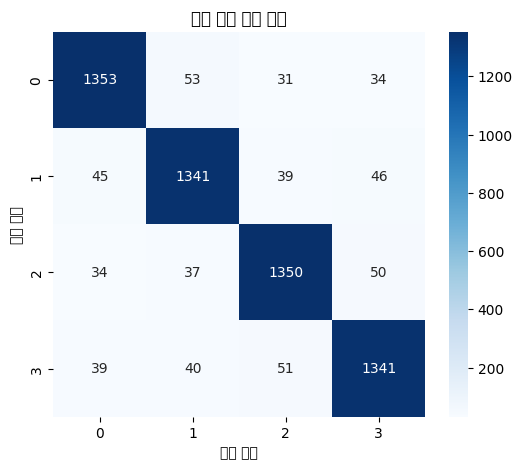

In [72]:
#④ 혼동 행렬 (Confusion Matrix) 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

gt_list = [[val_df.iloc[i][f"answer_{j}"] for j in range(4)] for i in range(len(val_df))]
pred_list = val_orders

gt_flat = np.array(gt_list).flatten()
pred_flat = np.array(pred_list).flatten()

cm = confusion_matrix(gt_flat, pred_flat, labels=[0,1,2,3])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("예측 위치")
plt.ylabel("정답 위치")
plt.title("문장 위치 혼동 행렬")
plt.show()


## 혼동행렬 분석 결과
- ✅ 결과 해석 (요약)
정답 → 예측	가장 많이 헷갈린 조합
0 → 1	53건 → 문장 0을 1번 위치로 착각
1 → 3	46건
2 → 3	50건
3 → 2	51건

  🔍 구체적 해석
대각선 값이 높을수록 (1350 이상) → 정확히 예측한 경우.

대각선 바깥 값은 오답인데, 특히 다음 케이스가 문제:

문장 2와 문장 3은 서로 자주 헷갈림 (2→3: 50건, 3→2: 51건)

문장 0은 거의 안 헷갈리는데도 0→1: 53건 존재함

후반 문장(2, 3) 사이의 연결성이 약하거나, 모델이 전개 흐름을 파악하지 못하고 있음

문장 0 → 1 착각은 시작 문장 판단 근거 부족을 의미

ex. [SEP]으로만 문장 구분했을 때, 첫 문장만의 특성 학습이 어렵다면 생김


### 개선 아이디어
| 문제           | 해결 방안                                                            |
| ------------ | ---------------------------------------------------------------- |
| 문장 0/1 구분 애매 | 문장 시작을 명확히 학습시키기 위한 **문장 위치 임베딩 추가**                             |
| 문장 2/3 혼동    | Pairwise loss 도입 or 후반 문장 강조 학습 (e.g. position-aware classifier) |
| 전체 미세 성능 향상  | 앙상블 (Global + Pairwise), 또는 warmup 증가, 학습 에폭 증가                  |

*위치 사용 모델*
01, 12	기존 Global 예측 유지
2~3	pairwise 모델로 sent_2 vs sent_3 우선순위 재결정
